<a href="https://colab.research.google.com/github/51rL1N5/Prova_Esig/blob/master/taxi_fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go


import folium
import folium.plugins

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()


Loading BokehJS ...

In [0]:
# Como o banco de dados é muito grnade, irei analizar-lo por blocos
# Que são suficientemente grandes para podermos supor que representam bem uma aproximação
# da estatística global.

# Logo após processar todos eles, é necessário fazer uma média das análises (estacionaridade)


chunksize = 10 ** 6

chunk = pd.read_csv('train.csv', nrows=chunksize)

In [16]:
# Olhando a cara dos dados

chunk.head()

key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [0]:
# Primeiro, vamos limpar os dados 

"""
----- Limpeza de coordenadas -------------

Sei que a latitude é um número limitado entre -90 <= lat <= 90  
Bem como a longitude é limitada entre -180 <= long <= 180

Então, irei eliminar dados que apresentarem esses dados expúrios

"""

chunk = chunk[
               ( abs(chunk['pickup_latitude']) <= 90 ) & ( abs(chunk['pickup_longitude']) <= 180 ) & ( abs(chunk['dropoff_latitude']) <= 90 ) & ( abs(chunk['dropoff_longitude']) <= 180 )
             ]

"""
----- Limpeza de taxas -------------------

Não faz sentido que tenhamos preço pago negativo
Logo, eliminaremos os dados que possuam tal característica

"""

chunk = chunk[
               (chunk['fare_amount'] >= 0)
             ]

"""
----- Limpeza do número de passageiros ------

De acordo com https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxi

No máximo 4 ou 5, acrescido de uma criança abaixo de 7 anos (que ficará no colo de um adulto) poderão ir no taxi

Logo, no máximo teremos 6 passageiros
"""

chunk = chunk[
               (chunk['passenger_count'] <=6)
             ]

"""
----- Remover, caso existam, dados nulos (faltantes) -------------
"""
chunk = chunk.drop(chunk[chunk.isnull().any(1)].index, axis=0)

Como temos dados que dependem de localizações, precisamos garantir que eles se encontram em localizações válidas. 

A partir desse site (https://www.travelmath.com/cities/New+York,+NY) vemos que as coordenadas da cidade de NY:

Latitude    =  40.7141667

Longitude = -74.0063889

Então, vamos ver como estão dispostos os pontos para saber se existe alguma irregularidade 

In [0]:
# Carregar o mapa

nyc_mapa = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')


# definir limites do mapa
# BB é Boundary Box
# E as componentes dele serão
# [ Limite inferior da longitude, limite superior da longitude, limite inferior da latitude, limite superior da latitude]

BB = (-74.5, -72.8, 40.5, 41.8)

BB_zoom = (-74.3, -73.7, 40.5, 40.9)


nyc_mapa_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [0]:
def filtrar_pela_BB (df, BB):
  return df[(df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
           ]

In [0]:
# Função para podermos plotar os dados no mapa

def plot_on_map(df, BB, mapa, s=10, alpha=0.2):
  fig, axs = plt.subplots(1, 2, figsize=(20,10))
  axs[0].scatter(df['pickup_longitude'], df['pickup_latitude'], zorder=1, alpha=alpha, c='r', s=s)
  axs[0].set_xlim((BB[0], BB[1]))
  axs[0].set_ylim((BB[2], BB[3]))
  axs[0].set_title('Pickup locations')
  axs[0].imshow(mapa, zorder=0, extent=BB)

  axs[1].scatter(df['dropoff_longitude'], df['dropoff_latitude'], zorder=1, alpha=alpha, c='r', s=s)
  axs[1].set_xlim((BB[0], BB[1]))
  axs[1].set_ylim((BB[2], BB[3]))
  axs[1].set_title('Dropoff locations')
  axs[1].imshow(mapa, zorder=0, extent=BB)
  

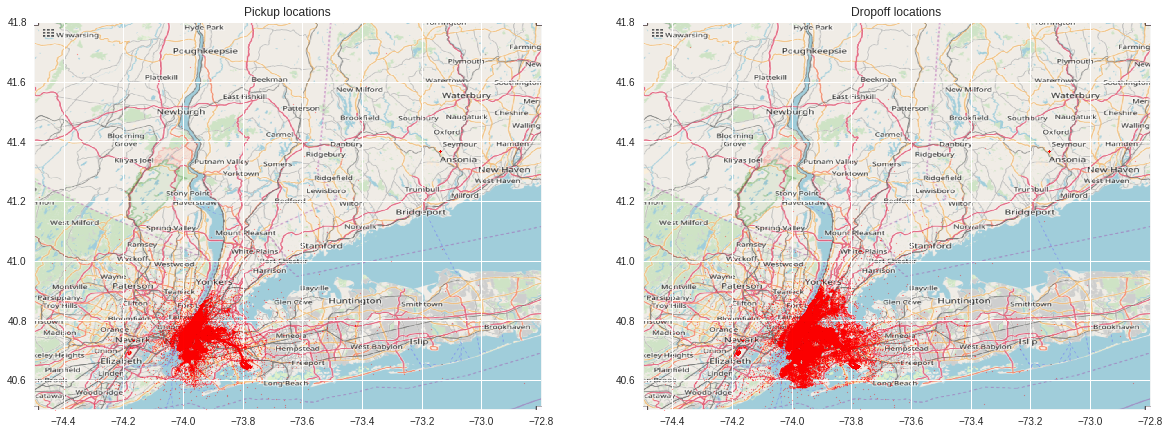

In [21]:
dados_BB = filtrar_pela_BB(chunk, BB)

plot_on_map(dados_BB, BB, nyc_mapa, s=1, alpha=0.3)

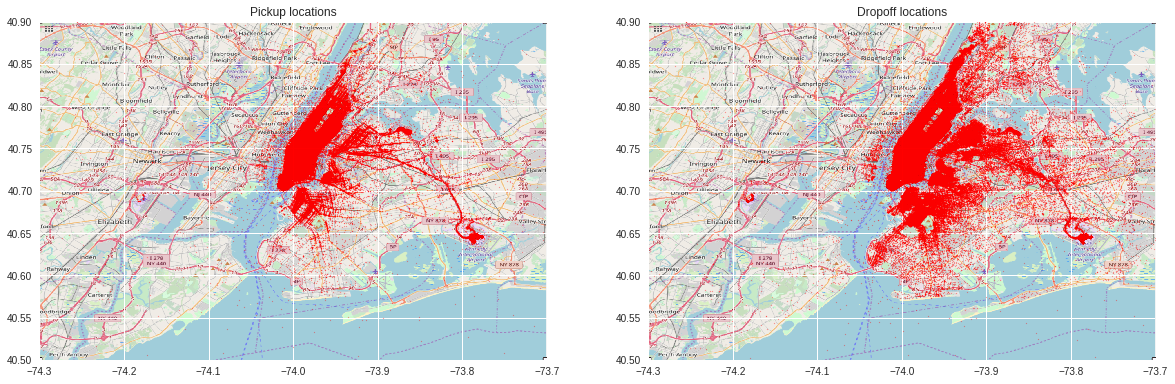

In [22]:
dados_BB_zoom = filtrar_pela_BB(chunk, BB_zoom)

plot_on_map(dados_BB_zoom, BB_zoom, nyc_mapa_zoom, s=1, alpha=0.3)

 **Como visto no gráfico acima, temos pontos em cima da água que são anomalias. Logo, devemos os remover**

Então, para remover os pontos acima da água podemos fazer o seguinte:

Vamos criar um mapa booleano terra/água




In [0]:
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

#plt.figure(figsize=(8,8))
#plt.imshow(nyc_mapa, zorder=0)
#plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.


def remove_datapoints_from_water(df, BB):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    #BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y   = lonlat_to_xy(df['pickup_longitude'], df['pickup_latitude'], 
                                        nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df['dropoff_longitude'], df['dropoff_latitude'], 
                                        nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index    
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]

    
    # return only datapoints on land
    return df[idx]
 



 
dados_BB = remove_datapoints_from_water(dados_BB, BB)

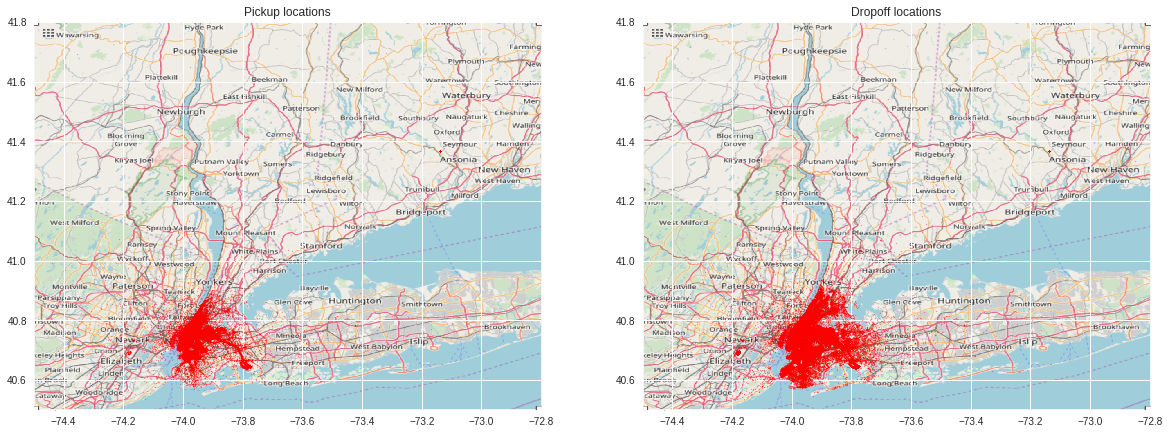

In [24]:
plot_on_map(dados_BB, BB, nyc_mapa, s=1, alpha=0.3)

In [0]:
chunk = dados_BB

In [26]:
# Agora, criaremos um indicador de distancia percorrida, bem como criarei mais colunas
# Com mais informação util, como Dia, Mês, Ano, hora, minuto, segundo


# Para calcularmos a distancia, se faz necessário usar a formula de haversine que pega dois pontos em uma esfera (latitude e longitude) e converte para distancia em metros

def haversine_1 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(chunk[lat1])
  phi_2 = np.radians(chunk[lat2])

  delta_phi    = np.radians(chunk[lat2] - chunk[lat1])
  delta_lambda = np.radians(chunk[long2] - chunk[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  chunk['distancia'] = d 
  return d
                                 

haversine_1('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0          1.030764
1          8.450134
2          1.389525
3          2.799270
4          1.999157
5          3.787239
6          1.555807
7          4.155444
8          1.253232
9          2.849627
10         1.374577
12         0.717767
13         2.019384
14         1.671445
16         2.609774
17         1.511904
18         0.921952
19         0.399179
20         1.686861
21         2.292470
22         0.924296
23         1.403958
24         1.017773
25         2.531947
27         0.328771
28         4.073463
29         0.808153
30         0.871913
31         6.703551
32         9.403296
            ...    
999970     1.800660
999971    16.888650
999972     0.443274
999973     0.509990
999974     6.774274
999975     9.357706
999976     4.093045
999977     5.314221
999978     1.842736
999979     3.689741
999980     4.456025
999981     3.622864
999982     1.162477
999983     0.806466
999984     8.401025
999985     1.344648
999986     0.821492
999987     0.240398
999988     0.000000


In [0]:
# converter string para date_time, para obtermos os dados temporais

chunk['key']             = pd.to_datetime(chunk['key'])

chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'])

In [28]:
# Olhando a cara dos atributos dos dados após a conversão

chunk.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distancia                   float64
dtype: object

In [0]:
# Separando os dados temporais para podermos visualizar-los melhor

chunk['Ano'] = chunk['pickup_datetime'].dt.year
chunk['Mes'] = chunk['pickup_datetime'].dt.month
chunk['Dia'] = chunk['pickup_datetime'].dt.day
chunk['Dia da semana'] = chunk['pickup_datetime'].dt.dayofweek
chunk['Horario'] = chunk['pickup_datetime'].dt.hour

In [0]:
# Colocar variáveis de estado para
# se está de:
# noite
# madrugada

def noite(x):
  if ((x['Horario'] <=20) & (x['Horario'] >=17) ):
    return 1
  else:
    return 0

def madrugada(x):
  if ((x['Horario'] <= 5) | (x['Horario'] >=21) ):
    return 1
  else:
    return 0
  
chunk['Noite'] = chunk.apply(lambda x: noite(x), axis=1)
chunk['Madrugada'] = chunk.apply(lambda x: madrugada(x), axis=1)


# **Análise exploratória de dados**

---



**Como é cobrada a taxa de taxi em NYC:**

1 - A taxa inicial é de **$2.50**

2 - Mais  **50 cents ** a cada 1/5 de Milha (0,321869 km) acima de 12 mph (19,3121 km/h) ou a cada minuto em tráfico devagar

3 - **50 cents**  de taxa adicional para todas viagens que terminam em NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange ou Putnam Counties

4 - ** 30 cents** de taxa de melhoramento

5 - ** 50 cents ** de taxa para tráfego entre **8pm** e **6am**

6 - ** $1.00 ** de taxa de hora do rush (**4pm ate 8pm**) em dias de semana, não se aplicando a feriados

7 -  Taxa de congestionamento de ** 2.50 ** (Taxi amarelo) , ** 2.75** (Taxi verde ou FHV) ou **75 cents** para corridas compartilhadas para todas as corridas que começam, terminam ou passam por Manhattan south of 96th street

8 - Pedágios e gorjetas são acrescidos caso necessário

**Hipóteses:**

1 - O Número de pessoas impacta no valor da taxa

2 - O horário o qual o taxi foi pego impacta no valor

3 - O dia da semana o qual o taxi foi pego impacta no valor

4 - Os meses impactam no valor da taxa?

5 - O local de origem do taxi tem relação com a taxa?

6 - A distância percorrida impacta no valor da taxa



#**Análise de correlação dos dados**

---



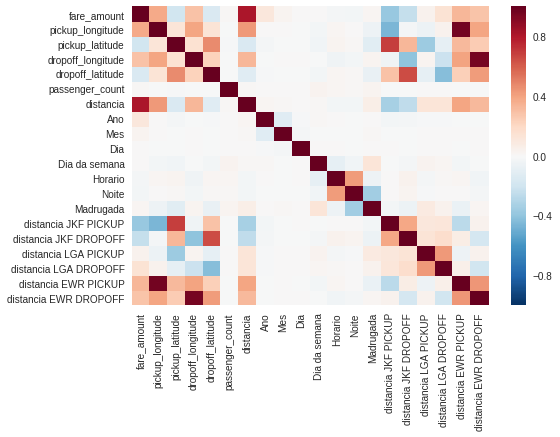

In [107]:
# Primeiro, vamos observar uma correlação dos dados para saber o que buscar de maneira mais eficiente

corr = chunk.corr()

sbs.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

##**Hipótese 1**

---
O número de pessoas impacta no valor da taxa?


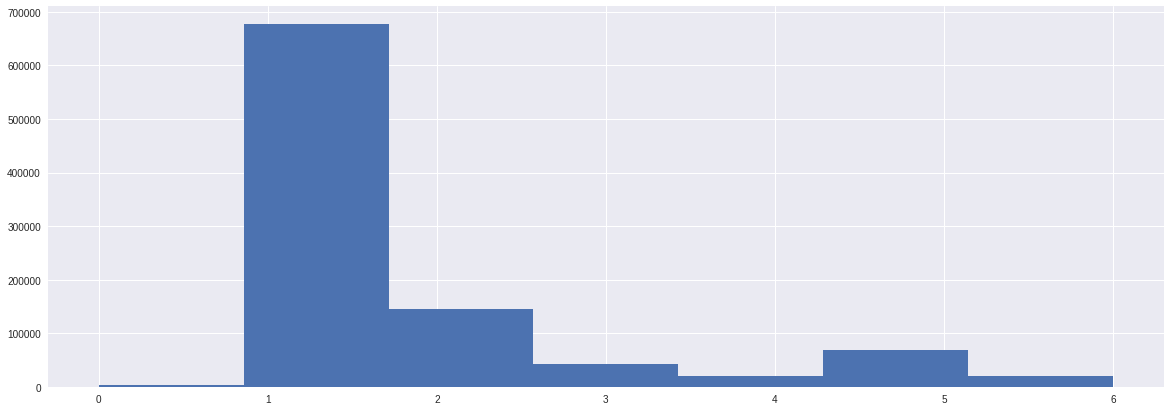

In [32]:
# Inicialmente, vamos ver a distribuição do número de pessoas

plt.figure(figsize=(20,7))

chunk['passenger_count'].hist(bins=7)

Text(0, 0.5, 'Taxa paga')

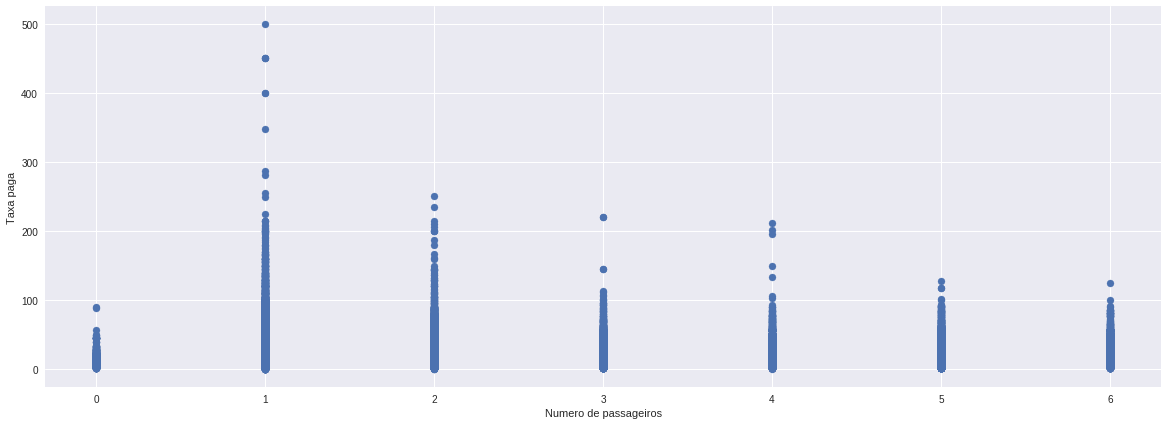

In [33]:
# Agora, é interessante ver como está a distribuição de número de passageiros x taxa paga

plt.figure(figsize=(20,7))

plt.scatter(x=chunk['passenger_count'], y=chunk['fare_amount'])
plt.xlabel('Numero de passageiros')
plt.ylabel('Taxa paga')

Dos dois gráficos, podemos inferir que a viagem de taxi para 1 passageiro é mais frequente. As taxas pagas mais altas também vem da viagem para 1 passageiro

#**Hipótese 2**

---

O horário impacta na taxa paga?

Text(0, 0.5, 'Frequencia')

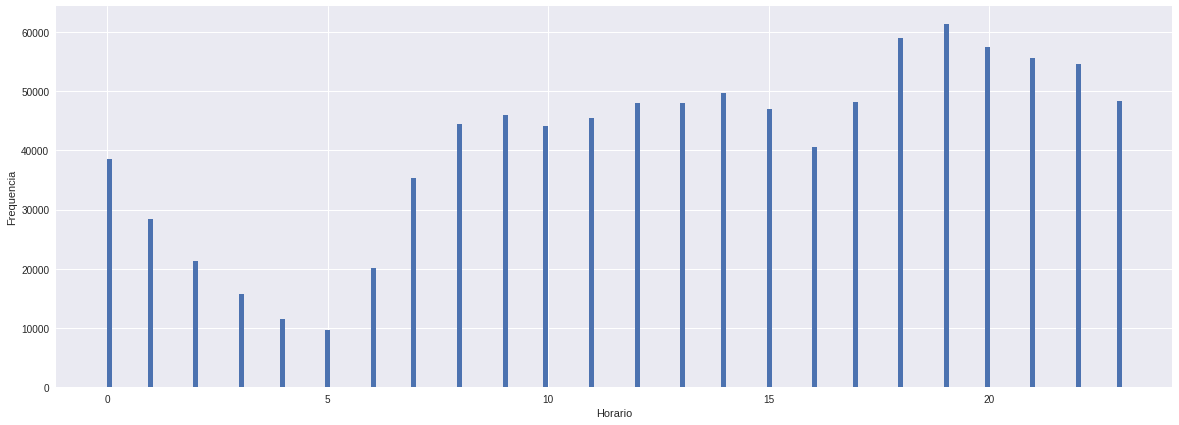

In [34]:
# Primeiro vamos estudar como está distribuida o horário os quais os taxis são pegos

plt.figure(figsize=(20,7))

chunk['Horario'].hist(bins=200)
plt.xlabel('Horario')
plt.ylabel('Frequencia')

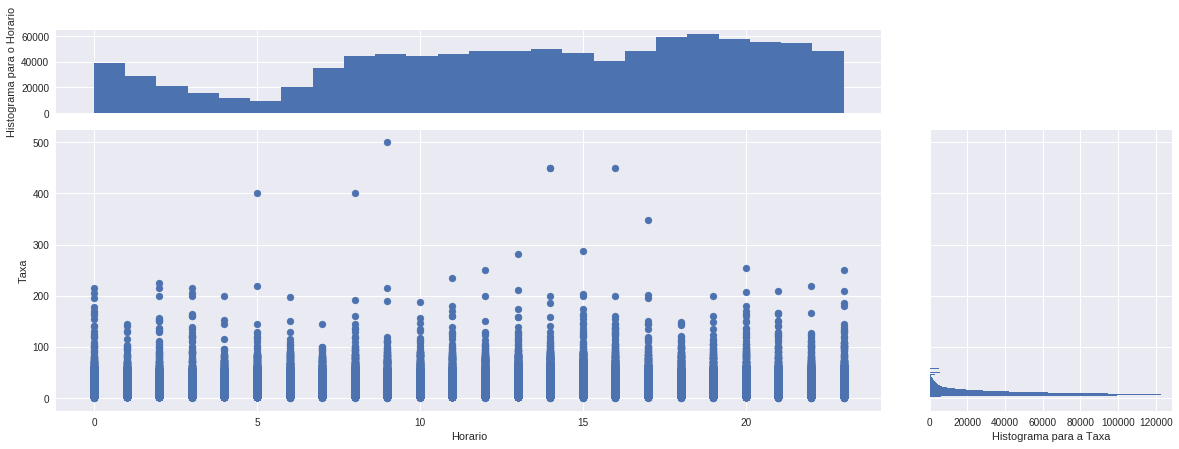

In [35]:


# plt.figure(figsize=(20,7))

# plt.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
# plt.xlabel('Horario')
# plt.ylabel('Taxa paga')


# Vamos ver como fica a distribuição do preço pago pelo horário


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()




(0, 20)

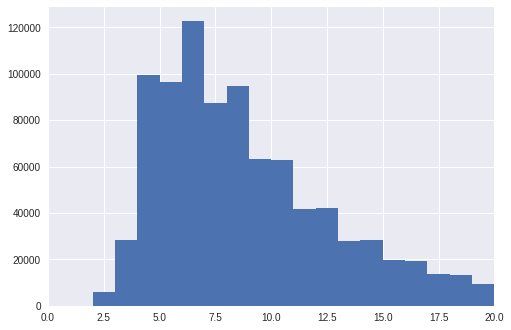

In [36]:
plt.hist(chunk['fare_amount'],bins=500)
plt.xlim((0,20))

In [37]:
chunk['fare_amount'].describe()

count    978831.000000
mean         11.329113
std           9.714595
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

Dos gráficos podemos inferir que ocorrem mais viagens entre as 18h e 21h, que é o horário em que geralmetne as pessoas voltam de seus trabalhos para casa. Todavia, o horário não parece impactar tanto no preço.

Também, vemos que a maioria das viagens custam, em média, 11.35 com um desvio padrão de 9.82


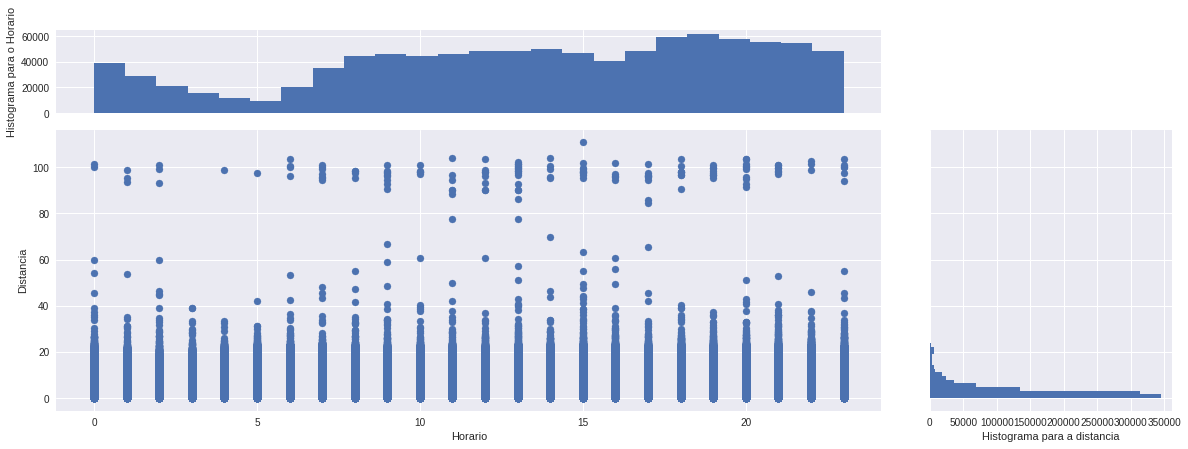

In [38]:
# Mas será que o horário impacta na distancia viajada?


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['distancia'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['distancia'],orientation="horizontal",bins=70)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Distancia')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a distancia')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()


Vemos que não, o horário não impacta na distância viajada.

#**Hipótese 3**


---
O dia da semana o qual o taxi foi pego impacta no valor?


Text(0, 0.5, 'Frequencia')

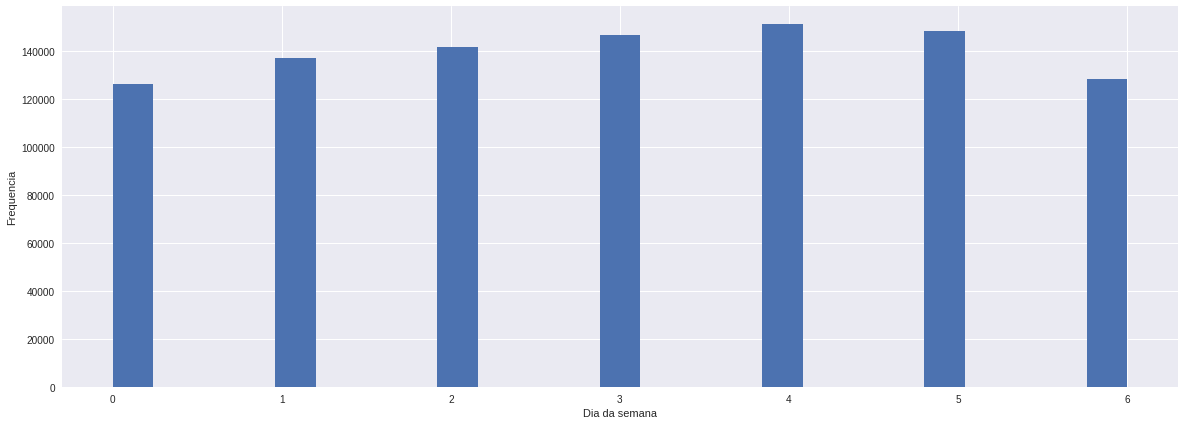

In [39]:
# Primeiro vamos estudar como está distribuida a demanda por taxis ao longo dos dias da semana

plt.figure(figsize=(20,7))

chunk['Dia da semana'].hist(bins=25)
plt.xlabel('Dia da semana')
plt.ylabel('Frequencia')

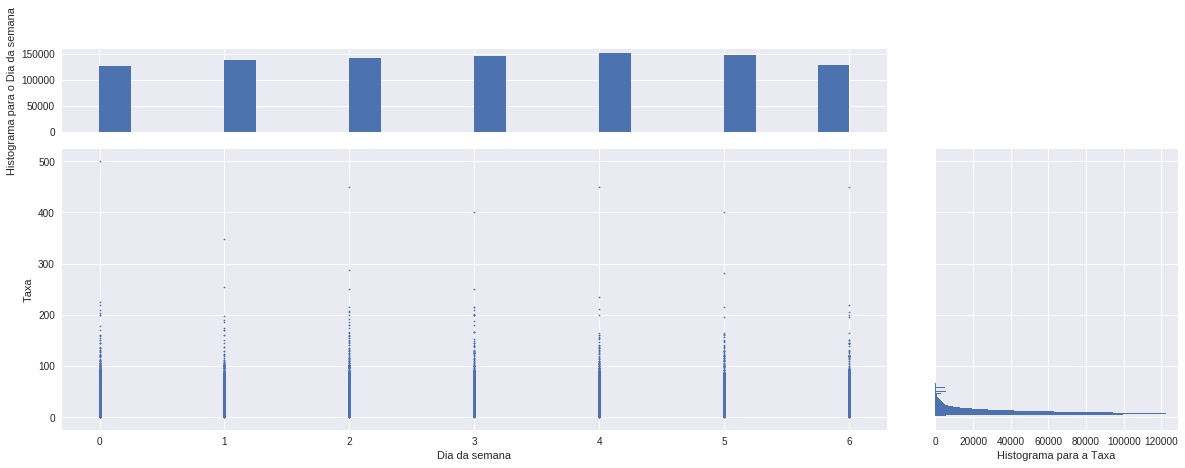

In [40]:
# Qual é a relação entre o dia da semana e ataxa paga?

fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])


ax_joint.scatter(x=chunk['Dia da semana'], y=chunk['fare_amount'],s=1.7)

ax_marg_x.hist(chunk['Dia da semana'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Dia da semana')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Dia da semana')
plt.show()


Podemos ver que o dia da semana que os taxis são mais requisitados é na quinta, 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



(0, 25)

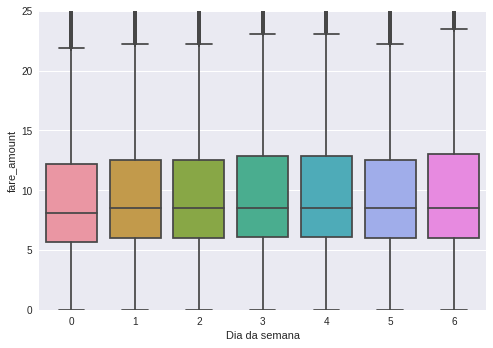

In [41]:
# fazendo uma análise usando o boxplot temos

sbs.boxplot(x='Dia da semana', y='fare_amount',data=chunk)
plt.ylim((0,25))

Observando as análises dos gráficos e dos boxplot, creio que não há muita relação entre a taxa e o dia da semana

#**Hipótese 4**


---

O local onde o taxi foi pego tem relação com a taxa?

In [0]:
#Vamos ver como fica um plot de densidade dos pickup e dropoff

def distance(lat1, long1, lat2, long2):
#     p = 0.017453292519943295 # Pi/180
#     a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
#     return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...
  R = 6371 # raio da terra em km

  phi_1 = np.radians(lat1)
  phi_2 = np.radians(lat2)

  delta_phi    = np.radians(lat2 - lat1)
  delta_lambda = np.radians(long2 - long1)

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km
  return d


  
# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays


bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(chunk.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(chunk.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(chunk.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(chunk.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

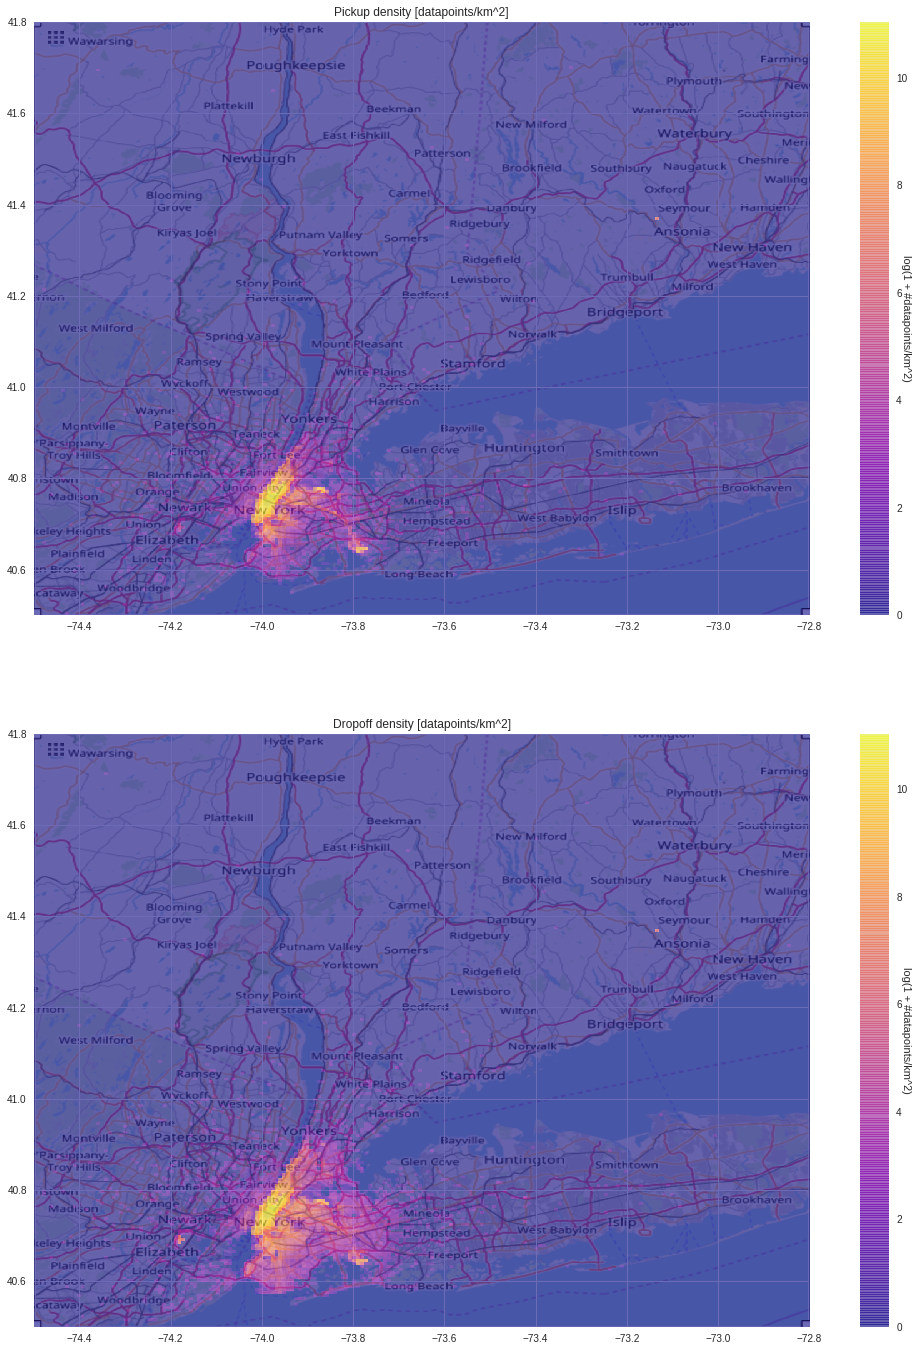

In [43]:
# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_mapa, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints/km^2]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints/km^2)', rotation=270)

axs[1].imshow(nyc_mapa, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints/km^2]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints/km^2)', rotation=270)


Observamos que temos 3 pontos mais afastados do centro de NYC (Manhattan). 

Ao procurar-los no google maps, vi que eles são 3 aeroportos: 

- Aeroporto John F. Kennedy (JKF)
  - Latitude: 40.6413
  - Longitude: -73.7781

- Aeroporto LaGuardia (LGA)
  - Latitude: 40.7769
  - Longitude:-73.8739

- Aeroporto Newark (EWR) 
  - Latitude: 40.7026
  - Longitude: -74.1878
  
  
Então, vamos analisar a taxa paga em função desses três focos de fluxo de taxi -- que estão mais evidentes no mapa

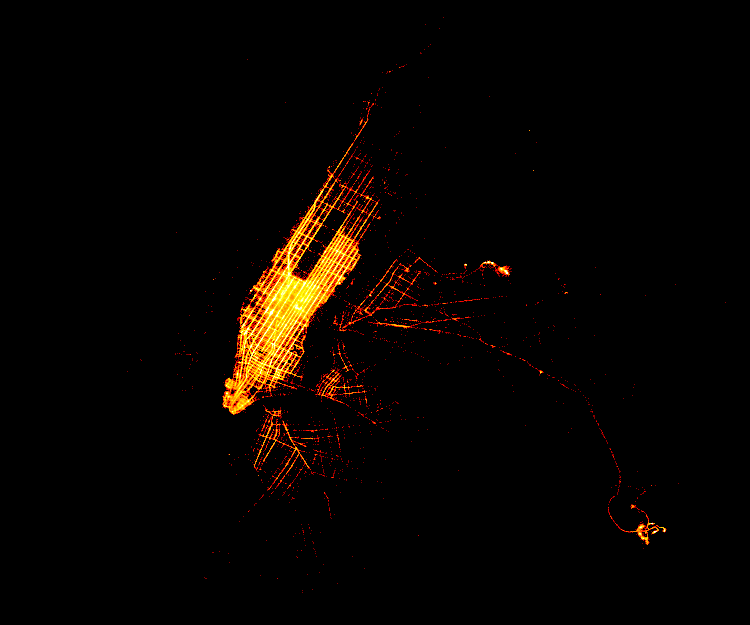

In [44]:
# função para plotar as coordenadas no mapa de NYC

def plot_data_points(longitude,latitude,data_frame,focus_point) :
    #plot dimensions
    x_range, y_range = ((-74.14,-73.73), (40.6,40.9))
    plot_width  = int(750)
    plot_height = int(plot_width//1.2)
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    #plot data points
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height,
                    x_range=x_range, y_range=y_range)
    agg = cvs.points(data_frame,longitude,latitude,
                      ds.count(focus_point))
    img = tf.shade(agg, cmap= Hot, how='eq_hist')
    image_xpt  =  tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,"NYCT_hot")


# taxa paga em função do ponto onde as pessoas pegam taxi
plot_data_points('pickup_longitude', 'pickup_latitude',chunk,'fare_amount')

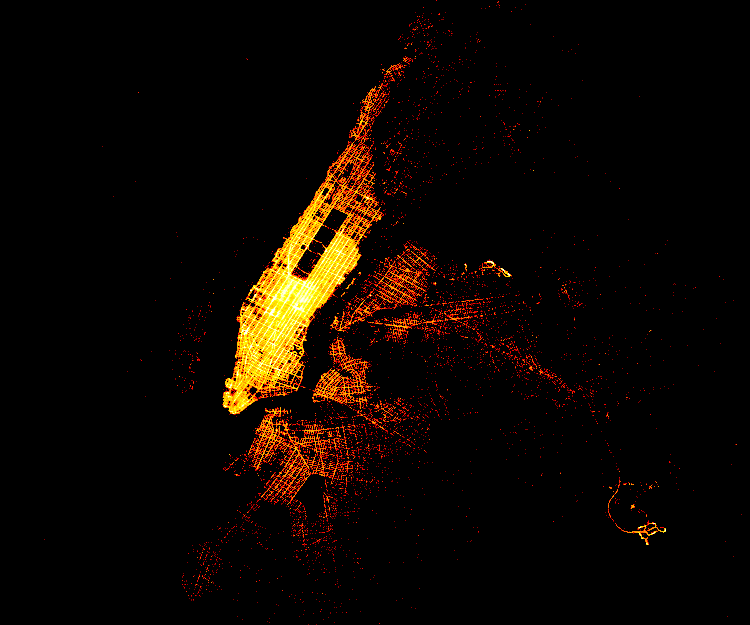

In [45]:
#Taxa paga em função do ponto em que são deixada as pessoas

plot_data_points('dropoff_longitude', 'dropoff_latitude',chunk,"fare_amount")

Observo que as maiores taxas são pagas por pessoas que:

- Vem ou vão para o JKF

- Vem ou vão para o LGA

- Estão no centro de Manhattan

Também, há esse fenômeno interessante de uma grande concentração de "pegar taxi" em Manhattan, e uma maior dispersão no "ponto de deixada" do taxi.
Possivelmente, as pessoas pegam taxi para se dirigir para suas casas. Explicando, assim o motivo da maior dispersão para os destinos em função da taxa paga.

In [0]:
# Vamos analisar brevemente como é o custo médio da tarifa para as pessoas que vão para os aeroportos

"""
- Aeroporto John F. Kennedy (JKF)
  - Latitude: 40.6413
  - Longitude: -73.7781

- Aeroporto LaGuardia (LGA)
  - Latitude: 40.7769
  - Longitude:-73.8739

- Aeroporto Newark (EWR) 
  - Latitude: 40.7026
  - Longitude: -74.1878
"""

# Pares Lat/long 

jkf = (40.6413, -73.7781)
lga = (40.7769, -73.8739)
ewr = (40.7026, -74.1878)


chunk['distancia JKF PICKUP']  = chunk.apply(lambda x: distance(jkf[0],jkf[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
chunk['distancia JKF DROPOFF'] = chunk.apply(lambda x: distance(jkf[0],jkf[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

chunk['distancia LGA PICKUP'] = chunk.apply(lambda x: distance(lga[0],lga[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
chunk['distancia LGA DROPOFF'] = chunk.apply(lambda x: distance(lga[0],lga[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

chunk['distancia EWR PICKUP'] = chunk.apply(lambda x: distance(ewr[0],ewr[1],x['pickup_latitude'],x['pickup_longitude']), axis=1)
chunk['distancia EWR DROPOFF'] = chunk.apply(lambda x: distance(ewr[0],ewr[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)



In [0]:
# Vamos ver como é a distribuição das viagens que partem dos aeroportos

# Primeiro vamos filtrar pelos destinos

indo_jkf   = chunk[chunk['distancia JKF PICKUP']  <2]
volta_jkf  = chunk[chunk['distancia JKF DROPOFF'] <2]

indo_lga   = chunk[chunk['distancia LGA PICKUP']  <2]
volta_lga  = chunk[chunk['distancia LGA DROPOFF'] <2]

indo_ewr   = chunk[chunk['distancia EWR PICKUP']  <2]
volta_ewr  = chunk[chunk['distancia EWR DROPOFF'] <2]

In [0]:
# Viagens que não vão para aeroporto algum

# remover os do jkf
not_aeroporto = chunk.drop(
                           indo_jkf.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_jkf.index, axis=0
                          )

# remover os do lga
not_aeroporto = chunk.drop(
                           indo_lga.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_lga.index, axis=0
                          )

# remover os do ewr
not_aeroporto = chunk.drop(
                           indo_ewr.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_ewr.index, axis=0
                          )


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



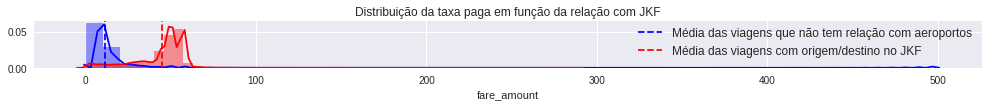

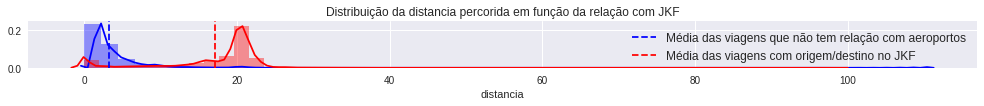

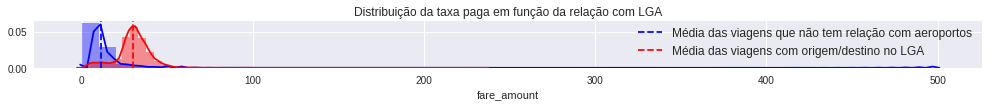

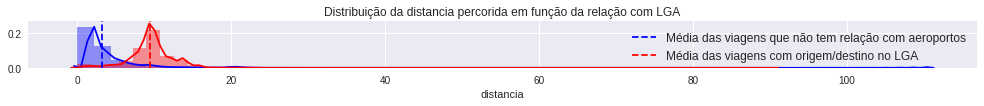

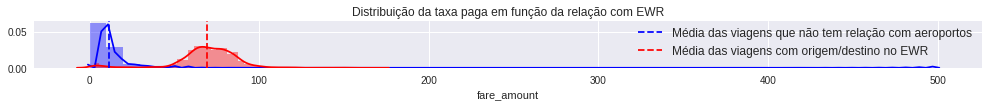

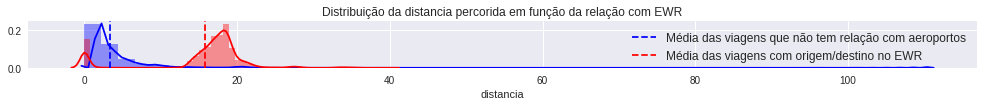

In [84]:
# Comparar a distribuição dos preços pagos e o aeroporto

# JKF

jkf_geral = pd.concat([indo_jkf, volta_jkf])


plt.figure(figsize= (17,6))
plt.subplot(611)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(jkf_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(jkf_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no JKF'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com JKF")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(612)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(jkf_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(jkf_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no JKF'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com JKF")
plt.show()
# FIM DA ANALISE DO JKF

# LGA

lga_geral = pd.concat([indo_lga, volta_lga])


plt.figure(figsize= (17,6))
plt.subplot(613)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(lga_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(lga_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no LGA'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com LGA")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(614)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(lga_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(lga_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no LGA'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com LGA")
plt.show()

# Fim da análise do LGA

# EWR

ewr_geral = pd.concat([indo_ewr, volta_ewr])


plt.figure(figsize= (17,6))
plt.subplot(615)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(ewr_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(ewr_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no EWR'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com EWR")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(616)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(ewr_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(ewr_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no EWR'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com EWR")
plt.show()


###Dos gráficos acima, observa-se que:

1 -  Em geral, corridas que estão relacionadas com aeroportos são mais caras
    
    - isso era esperado porque, como citado anteriormente, para corridas relacionadas a aeroportos existem taxas extras
    
    - Também, devido a maior distância que os aeroportos possuem do centro de NYC (Manhattan) impactará numa taxa maior
    
2 -  Corridas pegas no aeroporto LGA tendem a ser mais baratas

    - Uma possível justificativa é o fato do aeroporto está mais próximo a áreas residenciais/hotel -- ao contrário dos outros

3 - Corridas pegas no aeroporto EWR tendem a percorrer a ser mais caras
    
    - Novamente, devido a distância que o aeroporto tem das áreas residenciais e de hotel.

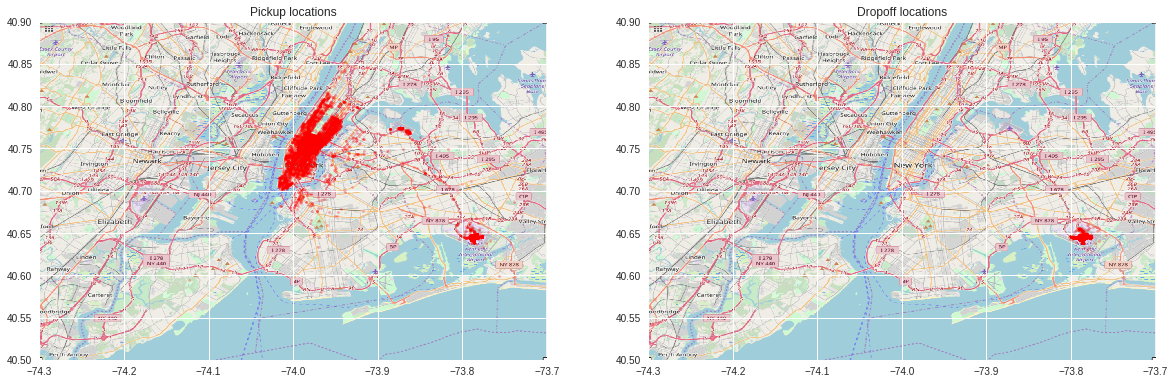

In [103]:
# Destinos relacioados ao JKF
plot_on_map(volta_jkf, BB_zoom, nyc_mapa_zoom, s=5, alpha=0.3)



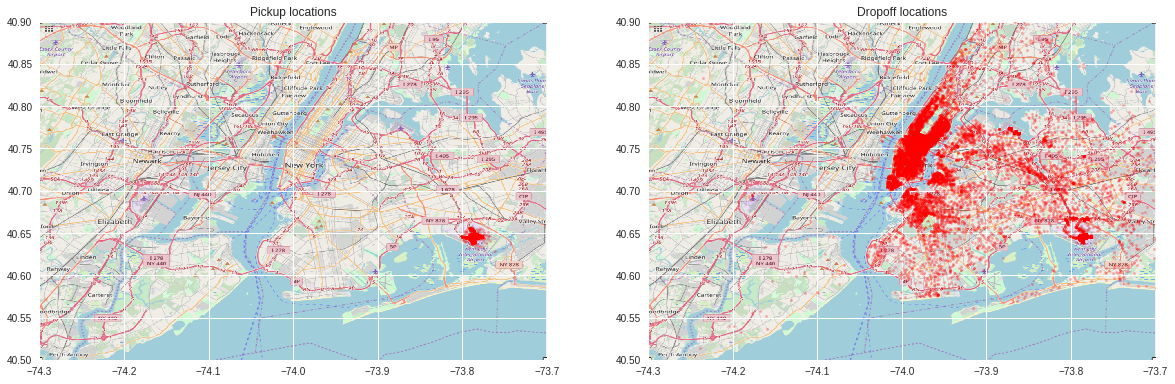

In [101]:
# Origens relacioados ao JKF
plot_on_map(indo_jkf, BB_zoom, nyc_mapa_zoom, s=5, alpha=0.3)


Observando estes gráficos, confirmo a minha hipótese de que 

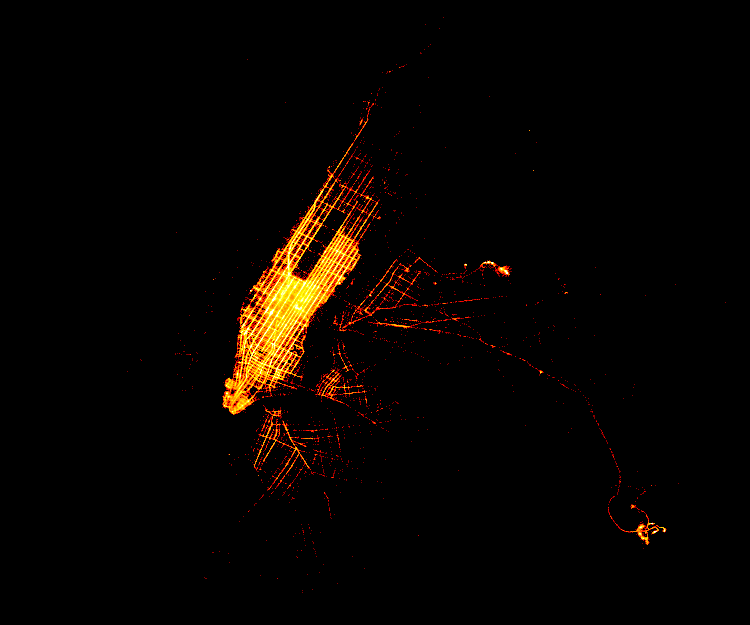

In [46]:
# Outra análise interessante a se fazer:

plot_data_points('pickup_longitude', 'pickup_latitude',chunk,'distancia')

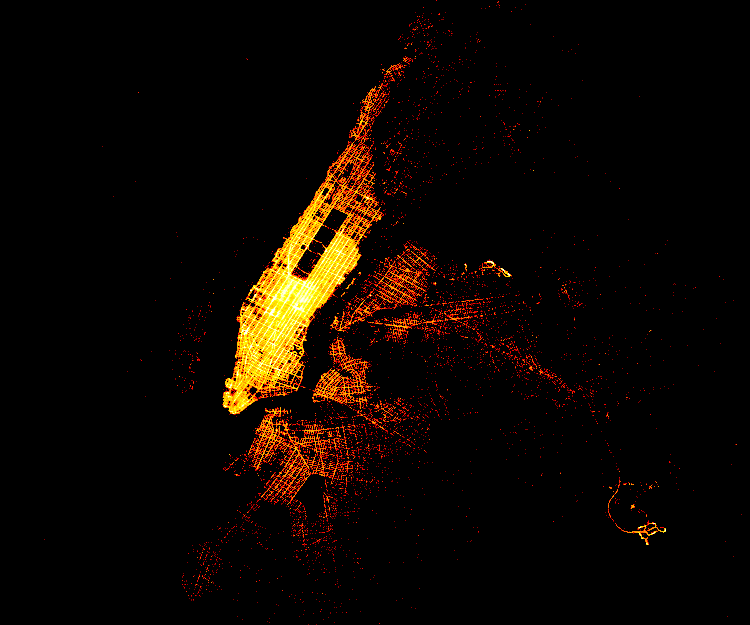

In [47]:
plot_data_points('dropoff_longitude', 'dropoff_latitude',chunk,"distancia")

Obtemos um comportamento parecido quando plotamos o mesmo gráfico, contudo com a intensidade do brilho variando de acordo com a distancia percorrida. Evidenciando, assim, que a distância está correlacionada com a taxa paga

# Machine Learning

---



In [0]:
test = pd.read_csv('test.csv')

In [105]:
test.head()

key          pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002  2015-01-27 13:08:24 UTC        -73.973320   
1  2015-01-27 13:08:24.0000003  2015-01-27 13:08:24 UTC        -73.986862   
2  2011-10-08 11:53:44.0000002  2011-10-08 11:53:44 UTC        -73.982524   
3  2012-12-01 21:12:12.0000002  2012-12-01 21:12:12 UTC        -73.981160   
4  2012-12-01 21:12:12.0000003  2012-12-01 21:12:12 UTC        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.763805         -73.981430         40.743835                1  
1        40.719383         -73.998886         40.739201                1  
2        40.751260         -73.979654         40.746139                1  
3        40.767807         -73.990448         40.751635                1  
4        40.789775         -73.988565         40.744427                1

Parâmetros

In [0]:
TRAIN_PATH      = 'train.csv'
TEST_PATH       = 'test.csv'
SUBMISSION_NAME = 'submission.csv'

BATCH_SIZE     = 256
EPOCHS         = 100
LEARNING_RATE  = 0.001
DATASET_SIZE   = 10**6



In [0]:
# Funções auxiliares
def output_submission(raw_test, prediction, id_column, prediction_column, file_name):
    df = pd.DataFrame(prediction, columns=[prediction_column])
    df[id_column] = raw_test[id_column]
    df[[id_column, prediction_column]].to_csv((file_name), index=False)
    print('Output complete')
    
    
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


In [0]:
# Adicionando features que usei na EDA para o teste

teste = remove_datapoints_from_water(test, BB)

teste['key']             = pd.to_datetime(teste['key'])

teste['pickup_datetime'] = pd.to_datetime(teste['pickup_datetime'])

teste['Ano'] = teste['pickup_datetime'].dt.year
teste['Mes'] = teste['pickup_datetime'].dt.month
teste['Dia'] = teste['pickup_datetime'].dt.day
teste['Dia da semana'] = teste['pickup_datetime'].dt.dayofweek
teste['Horario'] = chunk['pickup_datetime'].dt.hour

teste['Noite'] = teste.apply(lambda x: noite(x), axis=1)
teste['Madrugada'] = teste.apply(lambda x: madrugada(x), axis=1)

def haversine_2 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(teste[lat1])
  phi_2 = np.radians(teste[lat2])

  delta_phi    = np.radians(teste[lat2] - teste[lat1])
  delta_lambda = np.radians(teste[long2] - teste[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  teste['distancia'] = d 
  return d
                                 

haversine_2('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')



teste['distancia JKF PICKUP']  = teste.apply(lambda x: distance(jkf[0],jkf[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
teste['distancia JKF DROPOFF'] = teste.apply(lambda x: distance(jkf[0],jkf[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['distancia LGA PICKUP']  = teste.apply(lambda x: distance(lga[0],lga[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
teste['distancia LGA DROPOFF'] = teste.apply(lambda x: distance(lga[0],lga[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['distancia EWR PICKUP']  = teste.apply(lambda x: distance(ewr[0],ewr[1],x['pickup_latitude'],x['pickup_longitude']), axis=1)
teste['distancia EWR DROPOFF'] = teste.apply(lambda x: distance(ewr[0],ewr[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)


In [0]:
# eliminando features zoadas do teste
test_block  = teste.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','key','pickup_datetime'], axis=1)

# eliminando features que não servirão para o treino
train_block = chunk.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','key','pickup_datetime'], axis=1)


In [0]:
test_block = test_block.dropna()
train_block = train_block.dropna()

In [157]:
test_block.head()

passenger_count   Ano  Mes  Dia  Dia da semana  Horario  Noite  Madrugada  \
0                1  2015    1   27              1     17.0      1          0   
1                1  2015    1   27              1     16.0      0          0   
2                1  2011   10    8              5      0.0      0          1   
3                1  2012   12    1              5      4.0      0          1   
4                1  2012   12    1              5      7.0      0          0   

   distancia JKF PICKUP  distancia JKF DROPOFF  distancia LGA PICKUP  \
0             21.362956              20.588026              8.497987   
1             19.628684              21.564537             11.465415   
2             21.130815              20.607081              9.582230   
3             22.155528              21.702606              9.088679   
4             22.879752              21.127103              7.889229   

   distancia LGA DROPOFF  distancia EWR PICKUP  distancia EWR DROPOFF  
0               9.774463             19.310813              17.985348  
1              11.331161             17.038906              16.432523  
2               9.541090             18.124395              18.196287  
3              10.209712             18.860122              17.501153  
4              10.310479             21.046223              17.421992

In [158]:
train_block.head()

fare_amount  passenger_count  distancia   Ano  Mes  Dia  Dia da semana  \
0          4.5                1   1.030764  2009    6   15              0   
1         16.9                1   8.450134  2010    1    5              1   
2          5.7                2   1.389525  2011    8   18              3   
3          7.7                1   2.799270  2012    4   21              5   
4          5.3                1   1.999157  2010    3    9              1   

   Horario  Noite  Madrugada  distancia JKF PICKUP  distancia JKF DROPOFF  \
0       17      1          0             10.504346               9.538054   
1       16      0          0             21.523172              23.071126   
2        0      0          1             21.807027              21.690922   
3        4      0          1             20.369738              22.192143   
4        7      0          0             21.330886              21.850063   

   distancia LGA PICKUP  distancia LGA DROPOFF  distancia EWR PICKUP  \
0              6.664018               7.683303             29.025869   
1             14.021749               8.890126             14.509607   
2              9.328918              10.307357             18.469139   
3             10.706872              10.127635             17.249715   
4              7.993447               7.009536             19.888969   

   distancia EWR DROPOFF  
0              29.200615  
1              19.662123  
2              17.400778  
3              17.648839  
4              21.462669

In [0]:
train_df, validation_df = train_test_split(train_block, test_size=0.15, random_state=1)

# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)

In [163]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_block)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [183]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               4096      
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
__________

In [0]:
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)


Instructions for updating:
Use tf.cast instead.
Train on 832006 samples, validate on 146825 samples
Epoch 1/100
832006/832006 [==============================] - 62s 75us/step - loss: 44.0228 - mean_absolute_error: 3.7615 - val_loss: 22.9580 - val_mean_absolute_error: 2.7995
Epoch 2/100
210944/832006 [======>.......................] - ETA: 42s - loss: 21.9764 - mean_absolute_error: 2.1943

In [0]:
plot_loss_accuracy(history)

In [0]:
# Make prediction
prediction = model.predict(test_scaled, batch_size=128, verbose=1)

In [0]:
# output prediction
output_submission(test, prediction, 'key', 'fare_amount', SUBMISSION_NAME)